In [1]:
# Loading libraries
library(tidyverse)
library(digest)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 12)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [35]:
# Loading the data
ww_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
rw_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
ww <- read_delim(ww_url, delim = ";", col_names = TRUE)
rw <- read_delim(rw_url, delim = ";", col_names = TRUE)

colnames(ww) <- make.names(colnames(ww))
colnames(rw) <- make.names(colnames(rw))

Parsed with column specification:
cols(
  `fixed acidity` = col_double(),
  `volatile acidity` = col_double(),
  `citric acid` = col_double(),
  `residual sugar` = col_double(),
  chlorides = col_double(),
  `free sulfur dioxide` = col_double(),
  `total sulfur dioxide` = col_double(),
  density = col_double(),
  pH = col_double(),
  sulphates = col_double(),
  alcohol = col_double(),
  quality = col_double()
)

Parsed with column specification:
cols(
  `fixed acidity` = col_double(),
  `volatile acidity` = col_double(),
  `citric acid` = col_double(),
  `residual sugar` = col_double(),
  chlorides = col_double(),
  `free sulfur dioxide` = col_double(),
  `total sulfur dioxide` = col_double(),
  density = col_double(),
  pH = col_double(),
  sulphates = col_double(),
  alcohol = col_double(),
  quality = col_double()
)



fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.8,0.620,0.08,1.9,0.068,28,38,0.99651,3.42,0.82,9.5,6
6.2,0.600,0.08,2.0,0.090,32,44,0.99490,3.45,0.58,10.5,5


Below we summarize each dataset to gain preliminary insight into the datasets.

In [3]:
# Red wine summary statistics
"red wine statistics"
summary(rw)

# white wine summary statistics
"white wine statistics"
summary(ww)

[1] "red wine statistics"

 fixed.acidity   volatile.acidity  citric.acid    residual.sugar  
 Min.   : 4.60   Min.   :0.1200   Min.   :0.000   Min.   : 0.900  
 1st Qu.: 7.10   1st Qu.:0.3900   1st Qu.:0.090   1st Qu.: 1.900  
 Median : 7.90   Median :0.5200   Median :0.260   Median : 2.200  
 Mean   : 8.32   Mean   :0.5278   Mean   :0.271   Mean   : 2.539  
 3rd Qu.: 9.20   3rd Qu.:0.6400   3rd Qu.:0.420   3rd Qu.: 2.600  
 Max.   :15.90   Max.   :1.5800   Max.   :1.000   Max.   :15.500  
   chlorides       free.sulfur.dioxide total.sulfur.dioxide    density      
 Min.   :0.01200   Min.   : 1.00       Min.   :  6.00       Min.   :0.9901  
 1st Qu.:0.07000   1st Qu.: 7.00       1st Qu.: 22.00       1st Qu.:0.9956  
 Median :0.07900   Median :14.00       Median : 38.00       Median :0.9968  
 Mean   :0.08747   Mean   :15.87       Mean   : 46.47       Mean   :0.9967  
 3rd Qu.:0.09000   3rd Qu.:21.00       3rd Qu.: 62.00       3rd Qu.:0.9978  
 Max.   :0.61100   Max.   :72.00       Max.   :289.00       Max.   :1

[1] "white wine statistics"

 fixed.acidity    volatile.acidity  citric.acid     residual.sugar  
 Min.   : 3.800   Min.   :0.0800   Min.   :0.0000   Min.   : 0.600  
 1st Qu.: 6.300   1st Qu.:0.2100   1st Qu.:0.2700   1st Qu.: 1.700  
 Median : 6.800   Median :0.2600   Median :0.3200   Median : 5.200  
 Mean   : 6.855   Mean   :0.2782   Mean   :0.3342   Mean   : 6.391  
 3rd Qu.: 7.300   3rd Qu.:0.3200   3rd Qu.:0.3900   3rd Qu.: 9.900  
 Max.   :14.200   Max.   :1.1000   Max.   :1.6600   Max.   :65.800  
   chlorides       free.sulfur.dioxide total.sulfur.dioxide    density      
 Min.   :0.00900   Min.   :  2.00      Min.   :  9.0        Min.   :0.9871  
 1st Qu.:0.03600   1st Qu.: 23.00      1st Qu.:108.0        1st Qu.:0.9917  
 Median :0.04300   Median : 34.00      Median :134.0        Median :0.9937  
 Mean   :0.04577   Mean   : 35.31      Mean   :138.4        Mean   :0.9940  
 3rd Qu.:0.05000   3rd Qu.: 46.00      3rd Qu.:167.0        3rd Qu.:0.9961  
 Max.   :0.34600   Max.   :289.00      Max.   :440.0   

Below we convert the multi-categorical classes of quality to a binary variable where 0 represents "bad" or below average, and 1 represents "good" or above average. We purposefully do this to achieve better class balance as quality is approximately normally distributed between 5 and 6.

We split the classes based on the average quality score we calculate for each wine data set.

In [4]:
options(repr.plot.height = 15, repr.plot.width = 15)

# Calculating the wine quality averages
rw_avg <- mean(rw$quality)
ww_avg <- mean(ww$quality)

# Converting quality to binary scores as factors
rw_bin <- rw %>%
    mutate(binary.quality = as_factor(if_else(quality < rw_avg, 0,1)))

ww_bin <- ww %>%
    mutate(binary.quality = as_factor(if_else(quality < ww_avg, 0,1)))

# Converting quality to binary scores without factorizing
rw_bin_non_fct <- rw %>%
    mutate(binary.quality = if_else(quality < rw_avg, 0,1))

ww_bin_non_fct <- ww %>%
    mutate(binary.quality = if_else(quality < ww_avg, 0,1))

We use ggpairs() to create a summary of the variables and their respective distributions. We also use cor() to calcualate the correlations between each predictor variable and the response variable (binary_quality).


We use the information presented below to better inform which data set to use given its prospects for a fruitful data analysis.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



,binary.quality
,<dbl>
alcohol,0.434751205
volatile.acidity,-0.321440854
total.sulfur.dioxide,-0.231962976
sulphates,0.218071663
citric.acid,0.159129408
density,-0.159109969
chlorides,-0.109493996
fixed.acidity,0.095093490
free.sulfur.dioxide,-0.061756744


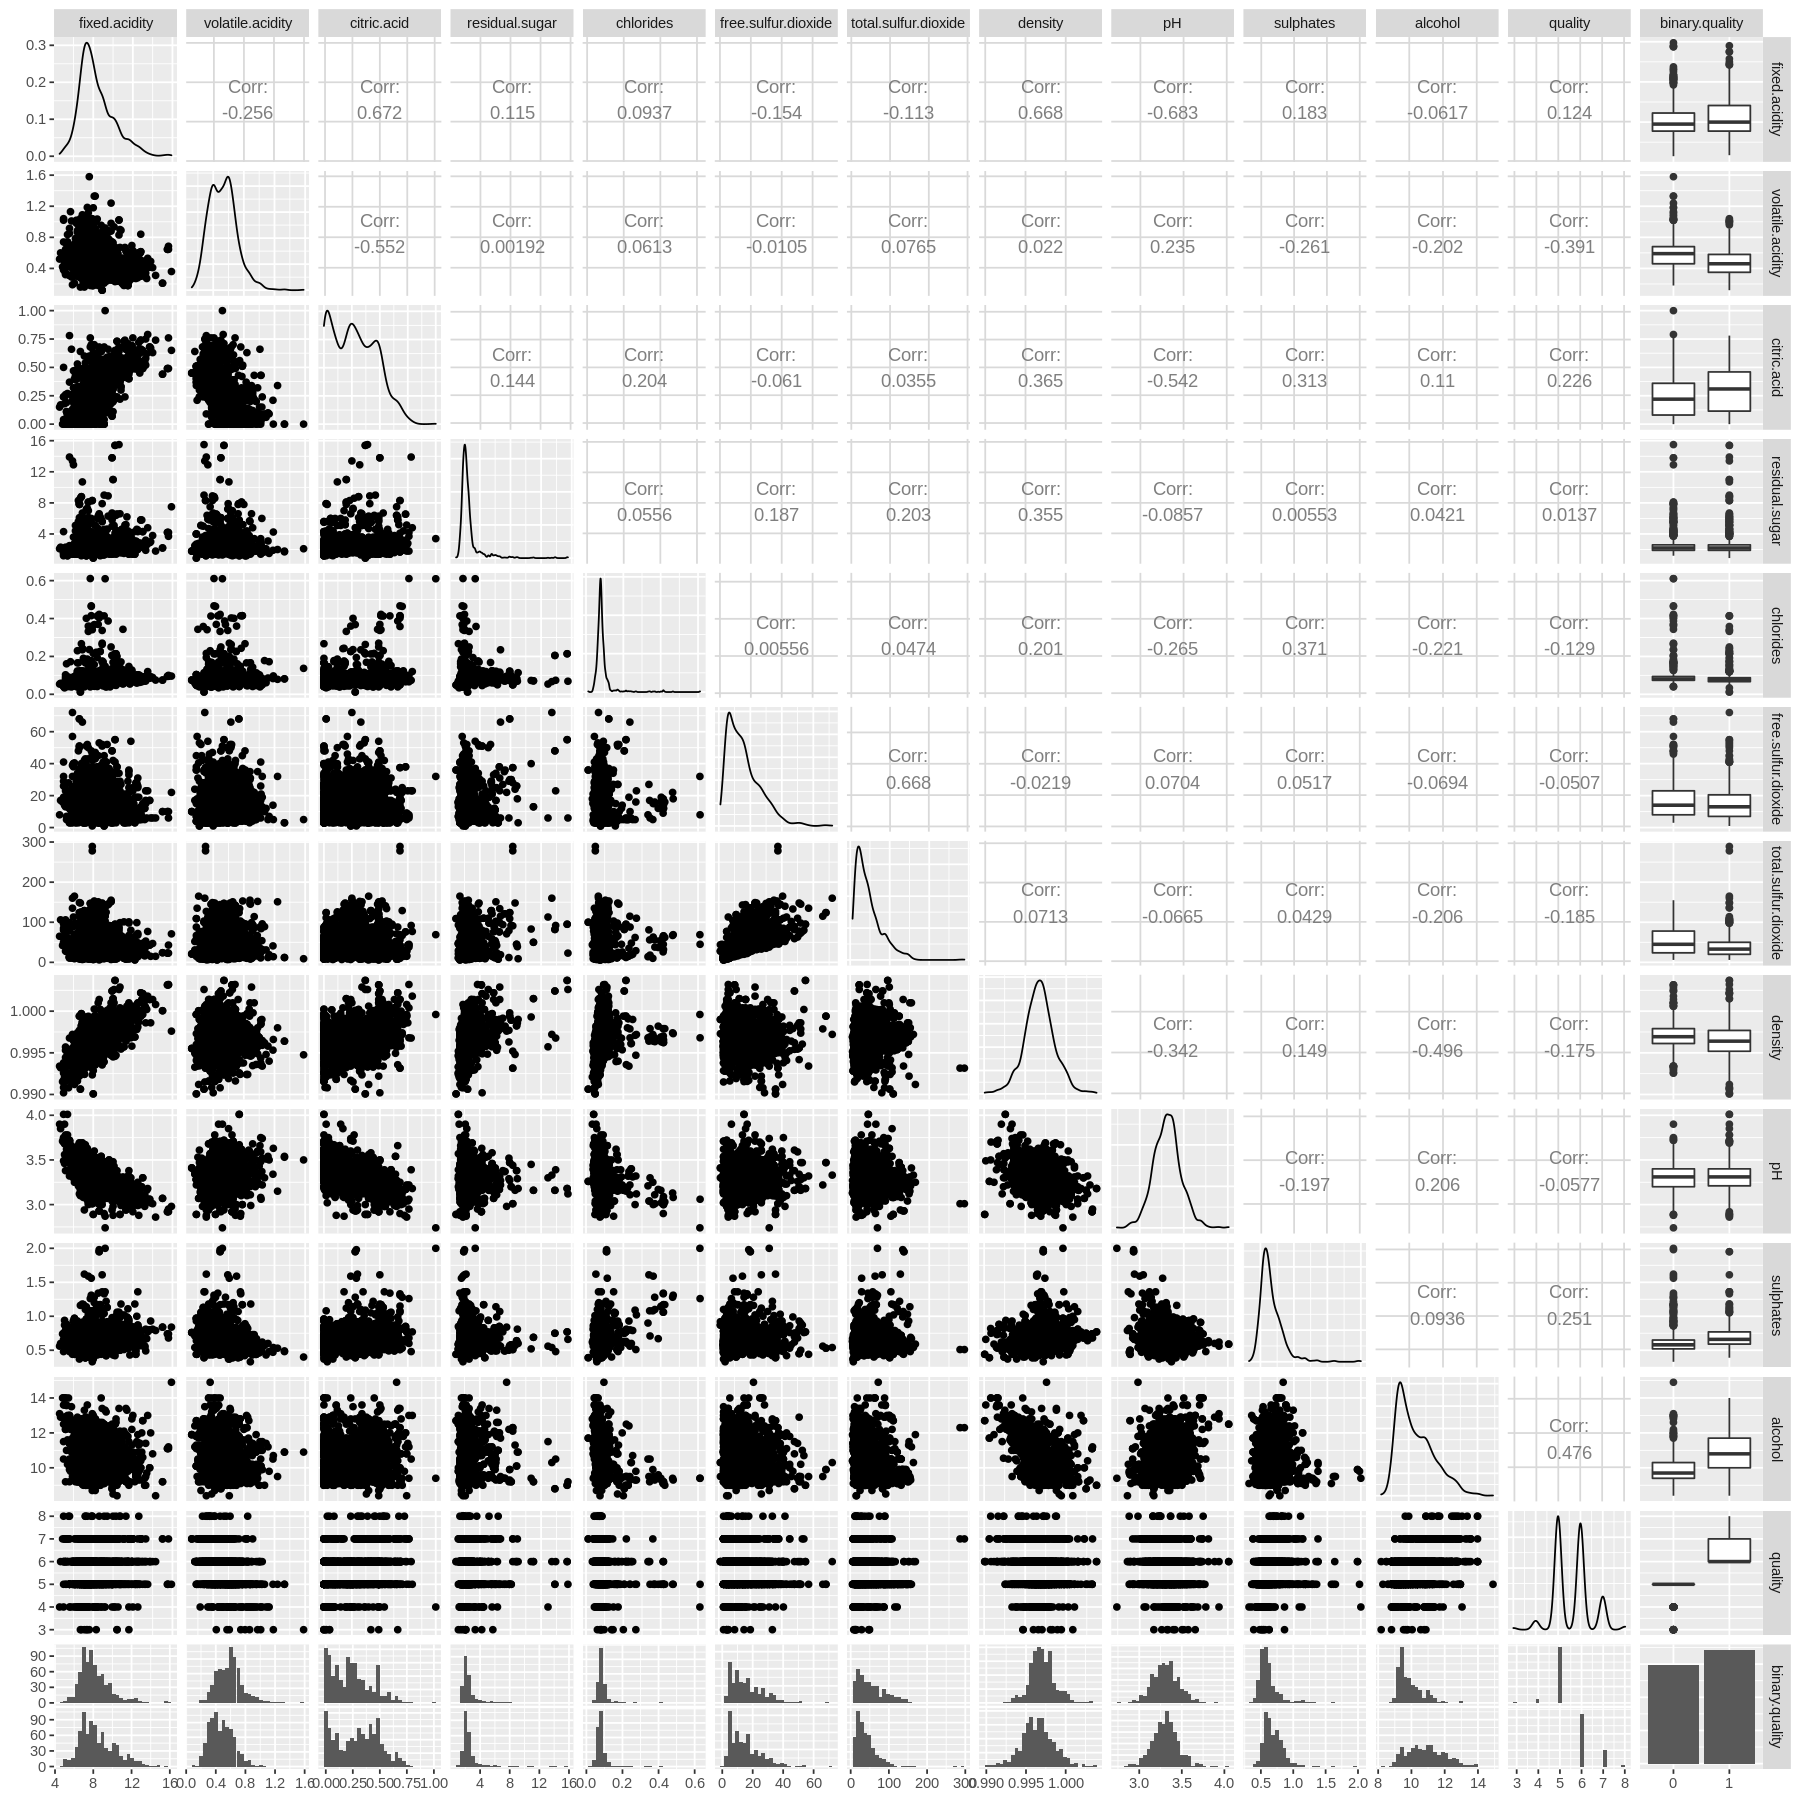

In [5]:
# Red wine plot and Pearson correlations
rw_plot <- ggpairs(rw_bin)

rw_corr <- rw_bin_non_fct %>%
    cor() %>% # cor() returns a vector, here we convert it to a data frame so we can use it
    as.data.frame() %>% 
    select(binary.quality) %>%
    arrange(desc(abs(binary.quality))) %>%
    tail(-2)

rw_plot
rw_corr

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



,binary.quality
,<dbl>
alcohol,0.3832799652
density,-0.2686955919
volatile.acidity,-0.2254399878
chlorides,-0.1839389663
total.sulfur.dioxide,-0.1709240272
residual.sugar,-0.0927563974
fixed.acidity,-0.0897490679
pH,0.0836872787
sulphates,0.0518577127


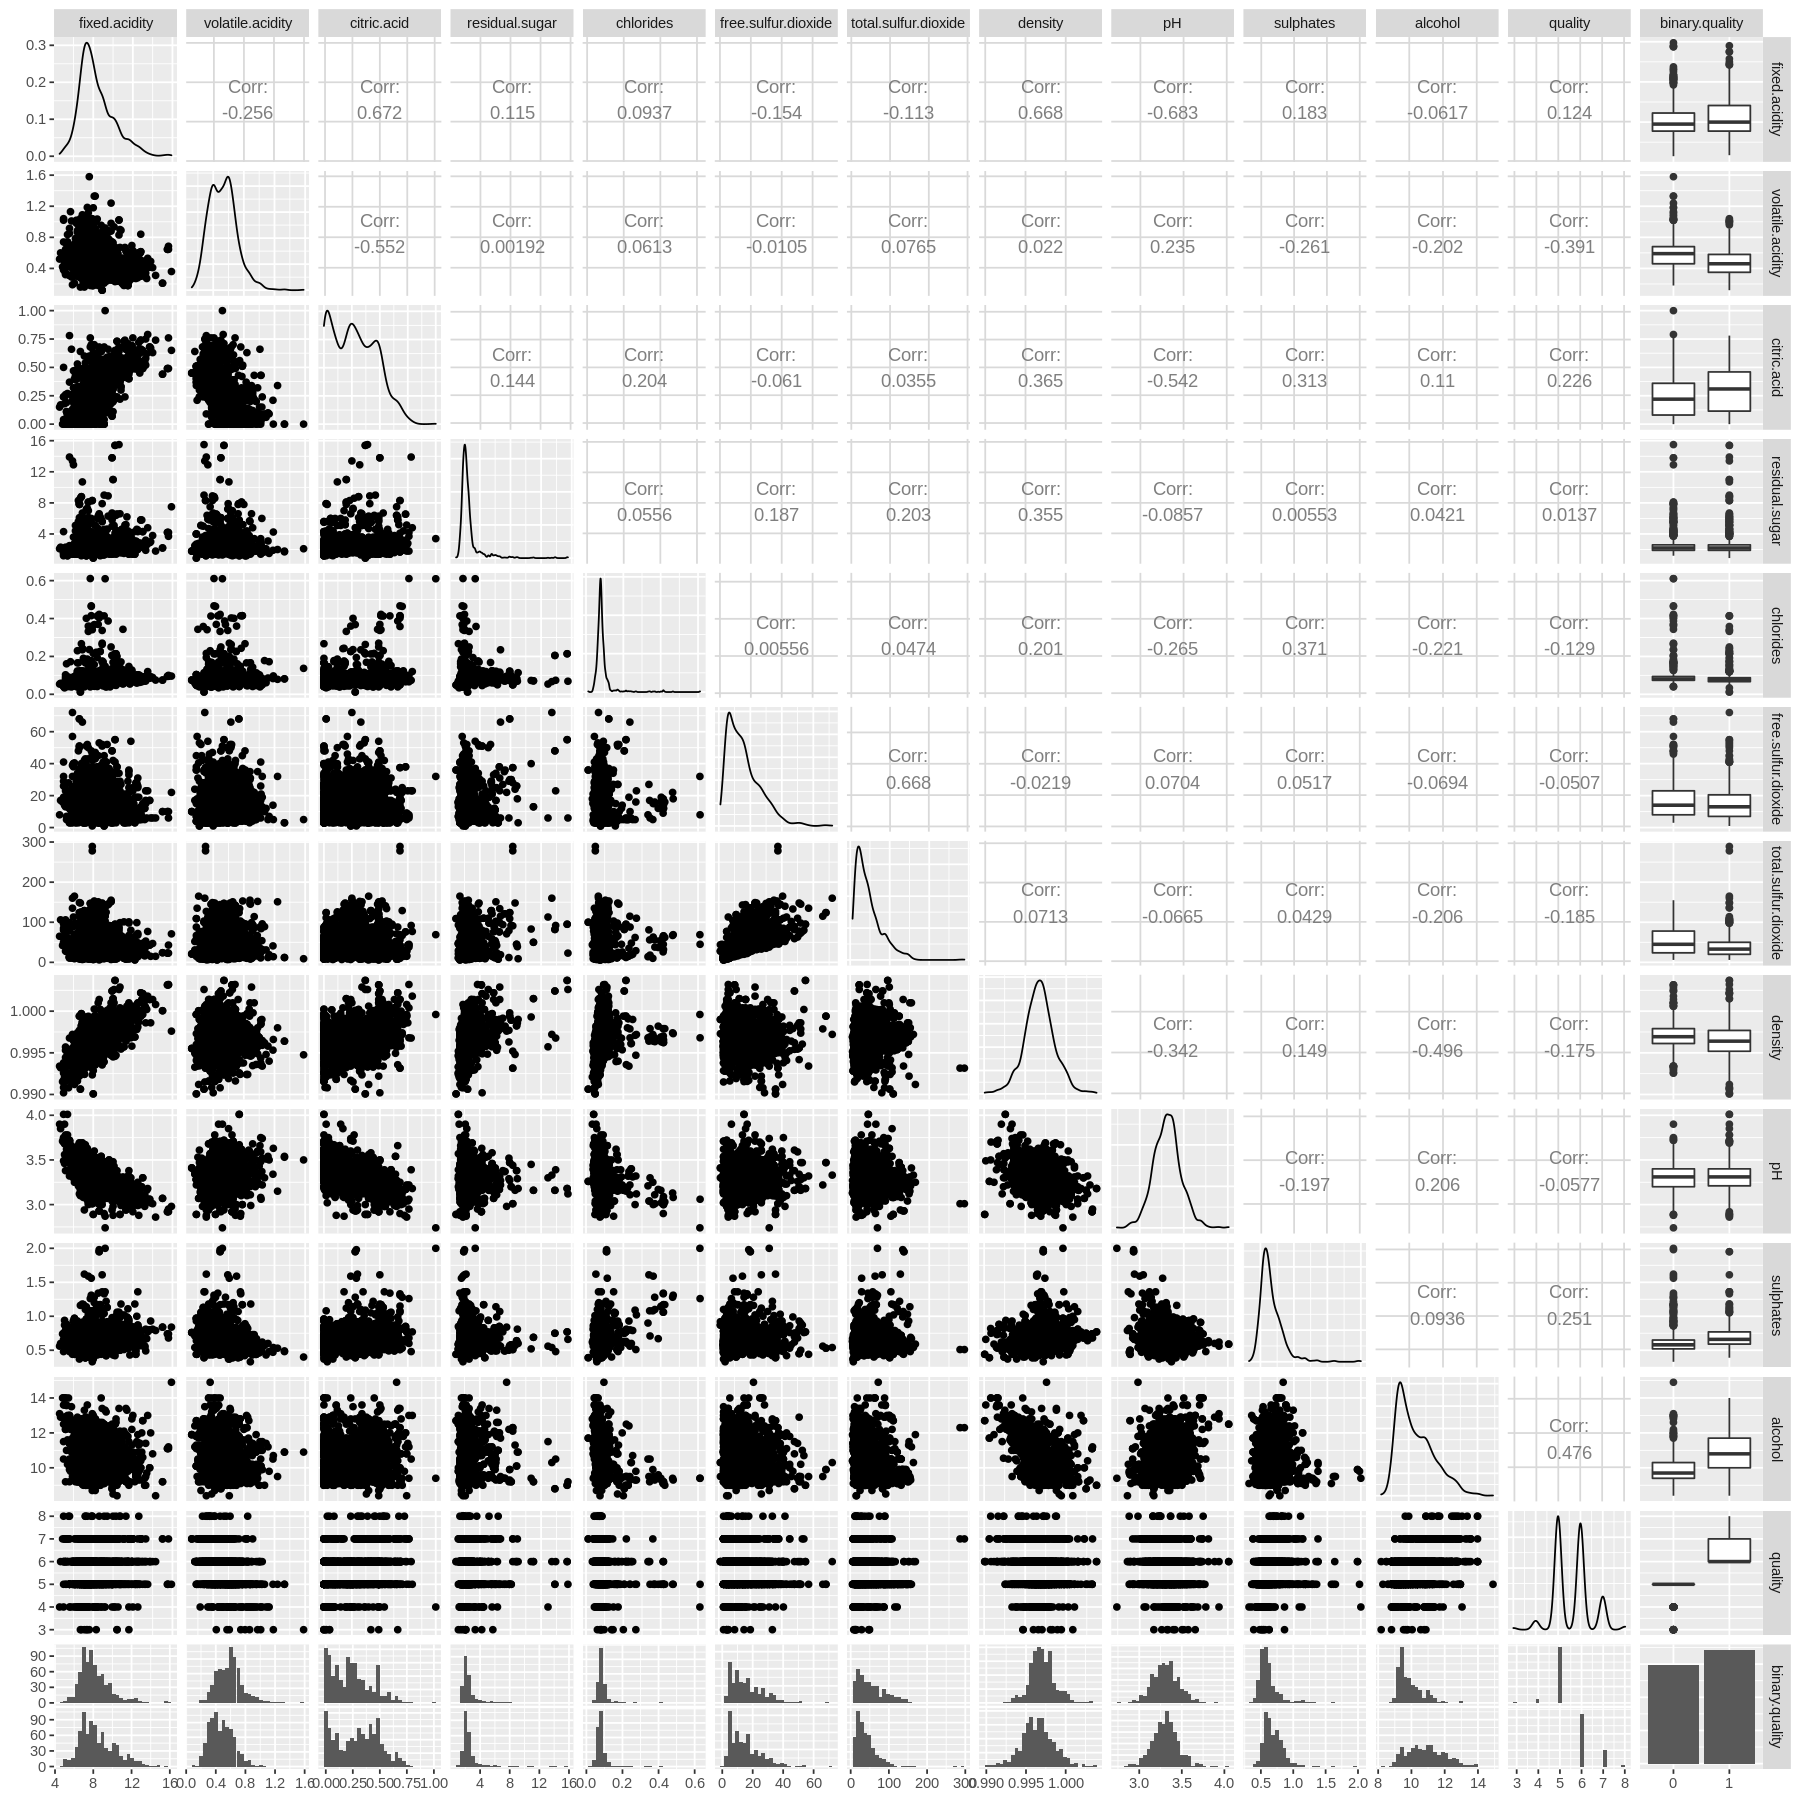

In [6]:
# White wine plot and Pearson correlations
ww_plot <- ggpairs(rw_bin)

ww_corr <- ww_bin_non_fct %>%
    cor() %>%
    as.data.frame() %>%
    select(binary.quality) %>%
    arrange(desc(abs(binary.quality))) %>%
    tail(-2)

ww_plot
ww_corr

Intuitively, it seems the quality of a red wine is more dependent on its physicochemical composition. We combine the tables below.

In [7]:
total_corr <- merge(ww_corr, rw_corr, by = 'row.names', all = TRUE) %>%
    rename("variables" = Row.names, "white.wine" = binary.quality.x, "red.wine" = binary.quality.y) %>%
    mutate("stronger.correl" = if_else(white.wine > red.wine, "white", "red"))

total_corr

variables,white.wine,red.wine,stronger.correl
<I<chr>>,<dbl>,<dbl>,<chr>
alcohol,0.3832799652,0.434751205,red
chlorides,-0.1839389663,-0.109493996,red
citric.acid,-0.0007004692,0.159129408,red
density,-0.2686955919,-0.159109969,red
fixed.acidity,-0.0897490679,0.095093490,red
free.sulfur.dioxide,-0.0012781194,-0.061756744,white
pH,0.0836872787,-0.003263984,white
residual.sugar,-0.0927563974,-0.002160450,red
sulphates,0.0518577127,0.218071663,red


Confirming our intuition, the quality of a red wine, all else equal, is more dependent on its physicochemical composition; of the 10 variables, red wines have stronger correlations for 6.

Therefore, to conduct a fruitful analysis, we will hereinafter use the red wine dataset for all analysis. We now visualize the distributions of the five strongest red wine correlations

variables,red.wine
<I<chr>>,<dbl>
alcohol,0.434751205
volatile.acidity,-0.321440854
total.sulfur.dioxide,-0.231962976
sulphates,0.218071663
citric.acid,0.159129408
density,-0.159109969
chlorides,-0.109493996
fixed.acidity,0.095093490
free.sulfur.dioxide,-0.061756744


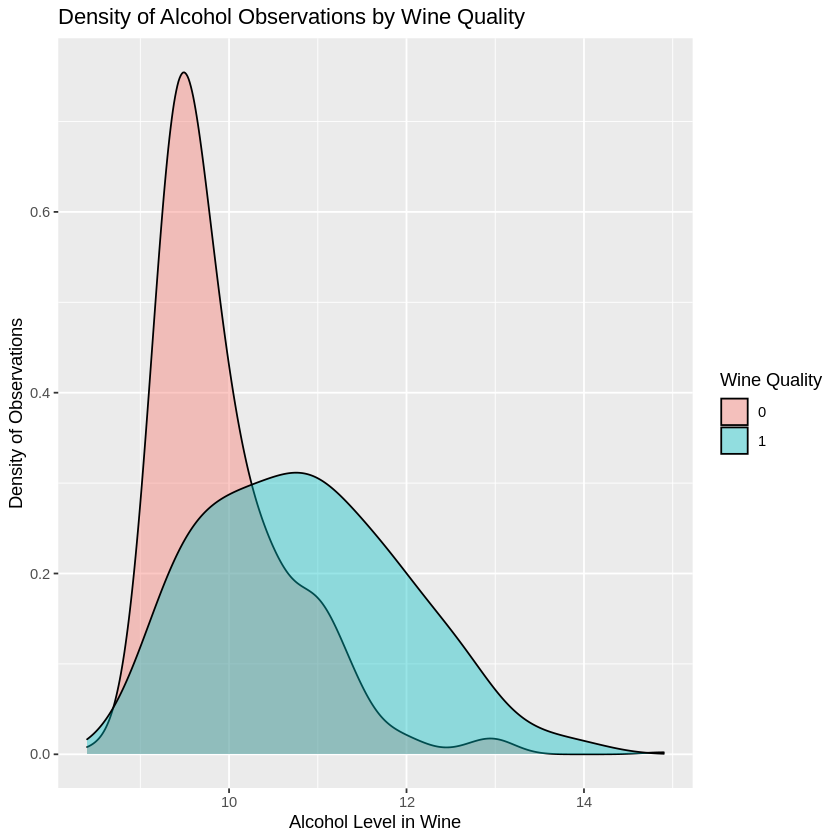

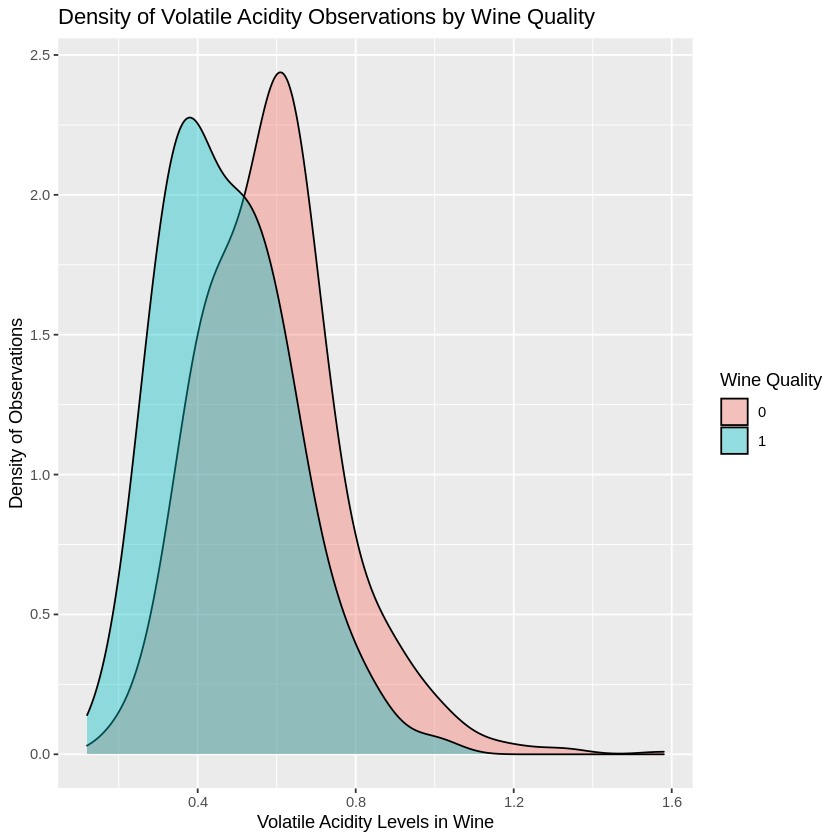

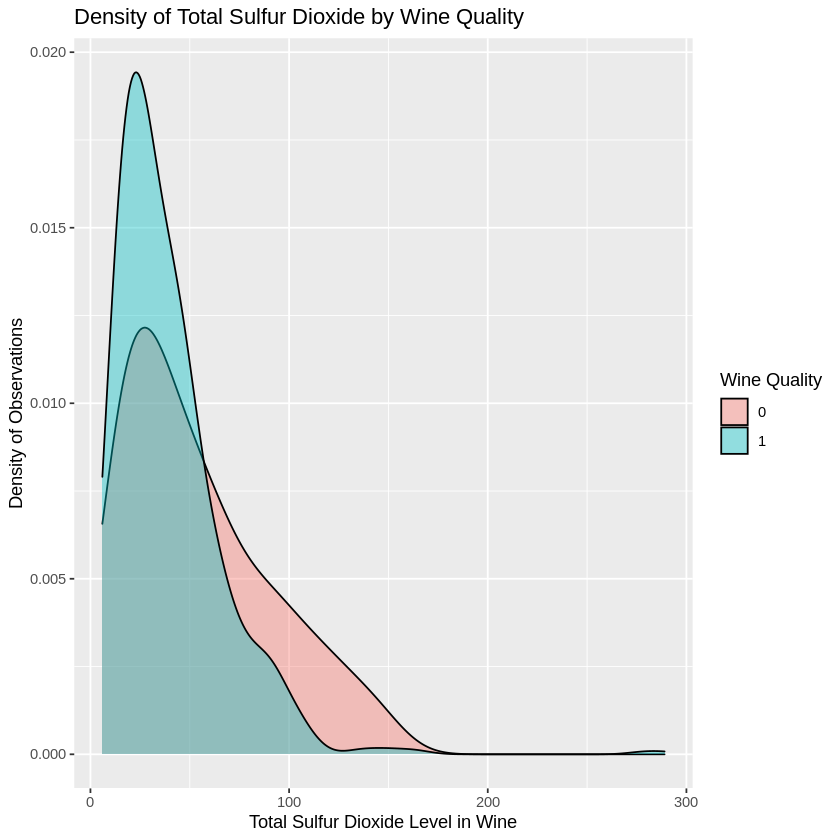

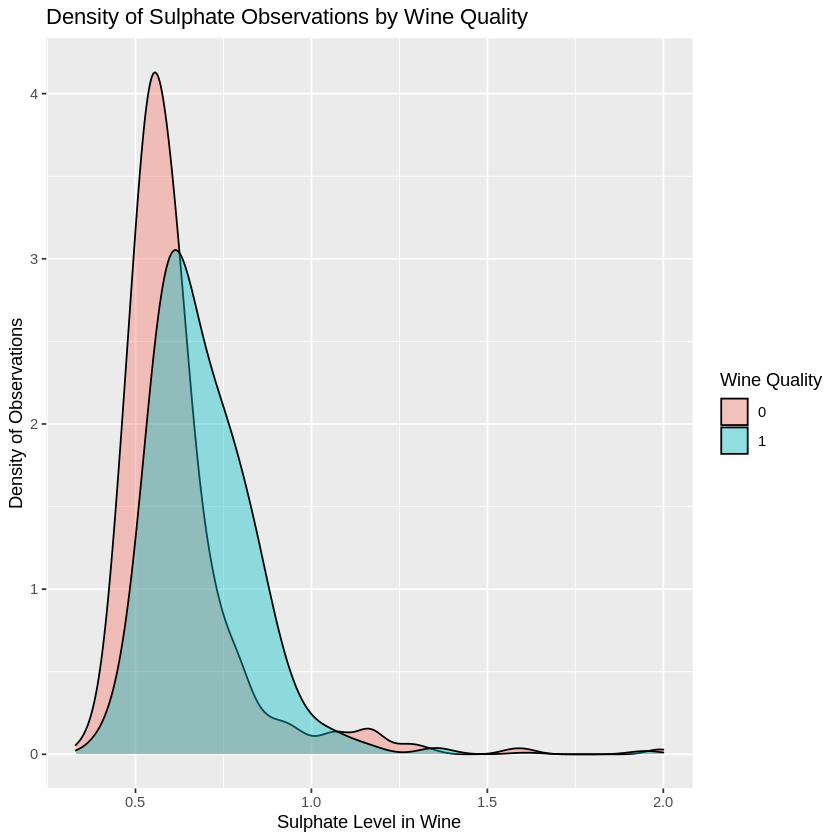

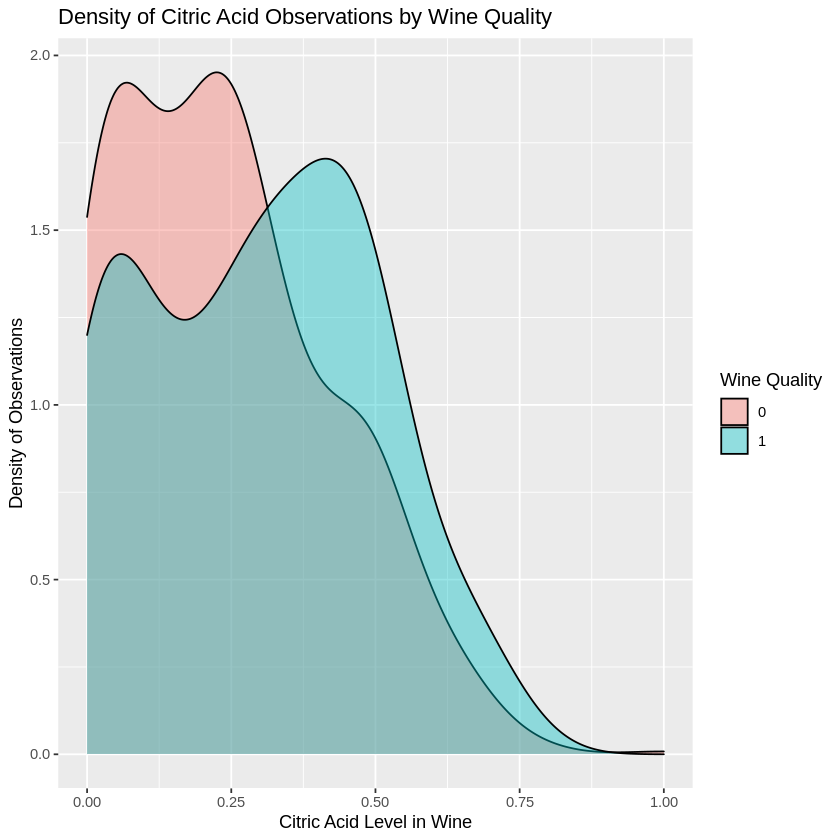

In [12]:
options(repr.plot.height = 7, repr.plot.width = 7)

# Ordering the strongest red wine correlations
rw_strongest <- total_corr %>%
    select(variables, red.wine) %>%
    arrange(desc(abs(red.wine)))

rw_strongest
# Alcohol density plot
alcohol_dens <- rw_bin %>%
    ggplot(aes(x = alcohol, group = binary.quality, fill = binary.quality)) +
    geom_density(adjust = 1.5, alpha = 0.4) +
    labs(x = "Alcohol Level in Wine", y = "Density of Observations", fill = "Wine Quality", title = "Density of Alcohol Observations by Wine Quality")

# Volatile acidity density plot
volatile_acidity_dens <- rw_bin %>%
    ggplot(aes(x = volatile.acidity, group = binary.quality, fill = binary.quality)) +
    geom_density(adjust = 1.5, alpha = 0.4) +
    labs(x = "Volatile Acidity Levels in Wine", y = "Density of Observations", fill = "Wine Quality", title = "Density of Volatile Acidity Observations by Wine Quality")

# Total sulfur dixoide plot
total_sulfur_dioxide_dens <- rw_bin %>%
    ggplot(aes(x = total.sulfur.dioxide, group = binary.quality, fill = binary.quality)) +
    geom_density(adjust = 1.5, alpha = 0.4) +
    labs(x = "Total Sulfur Dioxide Level in Wine", y = "Density of Observations", fill = "Wine Quality", title = "Density of Total Sulfur Dioxide by Wine Quality")

# Sulphates
sulphates_dens <- rw_bin %>%
    ggplot(aes(x = sulphates, group = binary.quality, fill = binary.quality)) +
    geom_density(adjust = 1.5, alpha = 0.4) +
    labs(x = "Sulphate Level in Wine", y = "Density of Observations", fill = "Wine Quality", title = "Density of Sulphate Observations by Wine Quality")

# Citric acid
citric_acid_dens <- rw_bin %>%
    ggplot(aes(x = citric.acid, group = binary.quality, fill = binary.quality)) +
    geom_density(adjust = 1.5, alpha = 0.4) +
    labs(x = "Citric Acid Level in Wine", y = "Density of Observations", fill = "Wine Quality", title = "Density of Citric Acid Observations by Wine Quality")

alcohol_dens
volatile_acidity_dens
total_sulfur_dioxide_dens
sulphates_dens
citric_acid_dens

As exhibited in the above plots, alcohol level has the highest positive correlation to the quality of a red wine. The following plots also show moderately significant correlations, so we must decide which to use as to obtain the highest accuracy. This process is called feature selection and we will be using a forward selection process.  

In [22]:
options(repr.plot.width = 12, repr.plot.height = 12)
set.seed(4862)

We first split into a testing and training dataset with 75-25 balance and then downsample the majority class to the minority class size, such that size(majority) == size(minority).

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


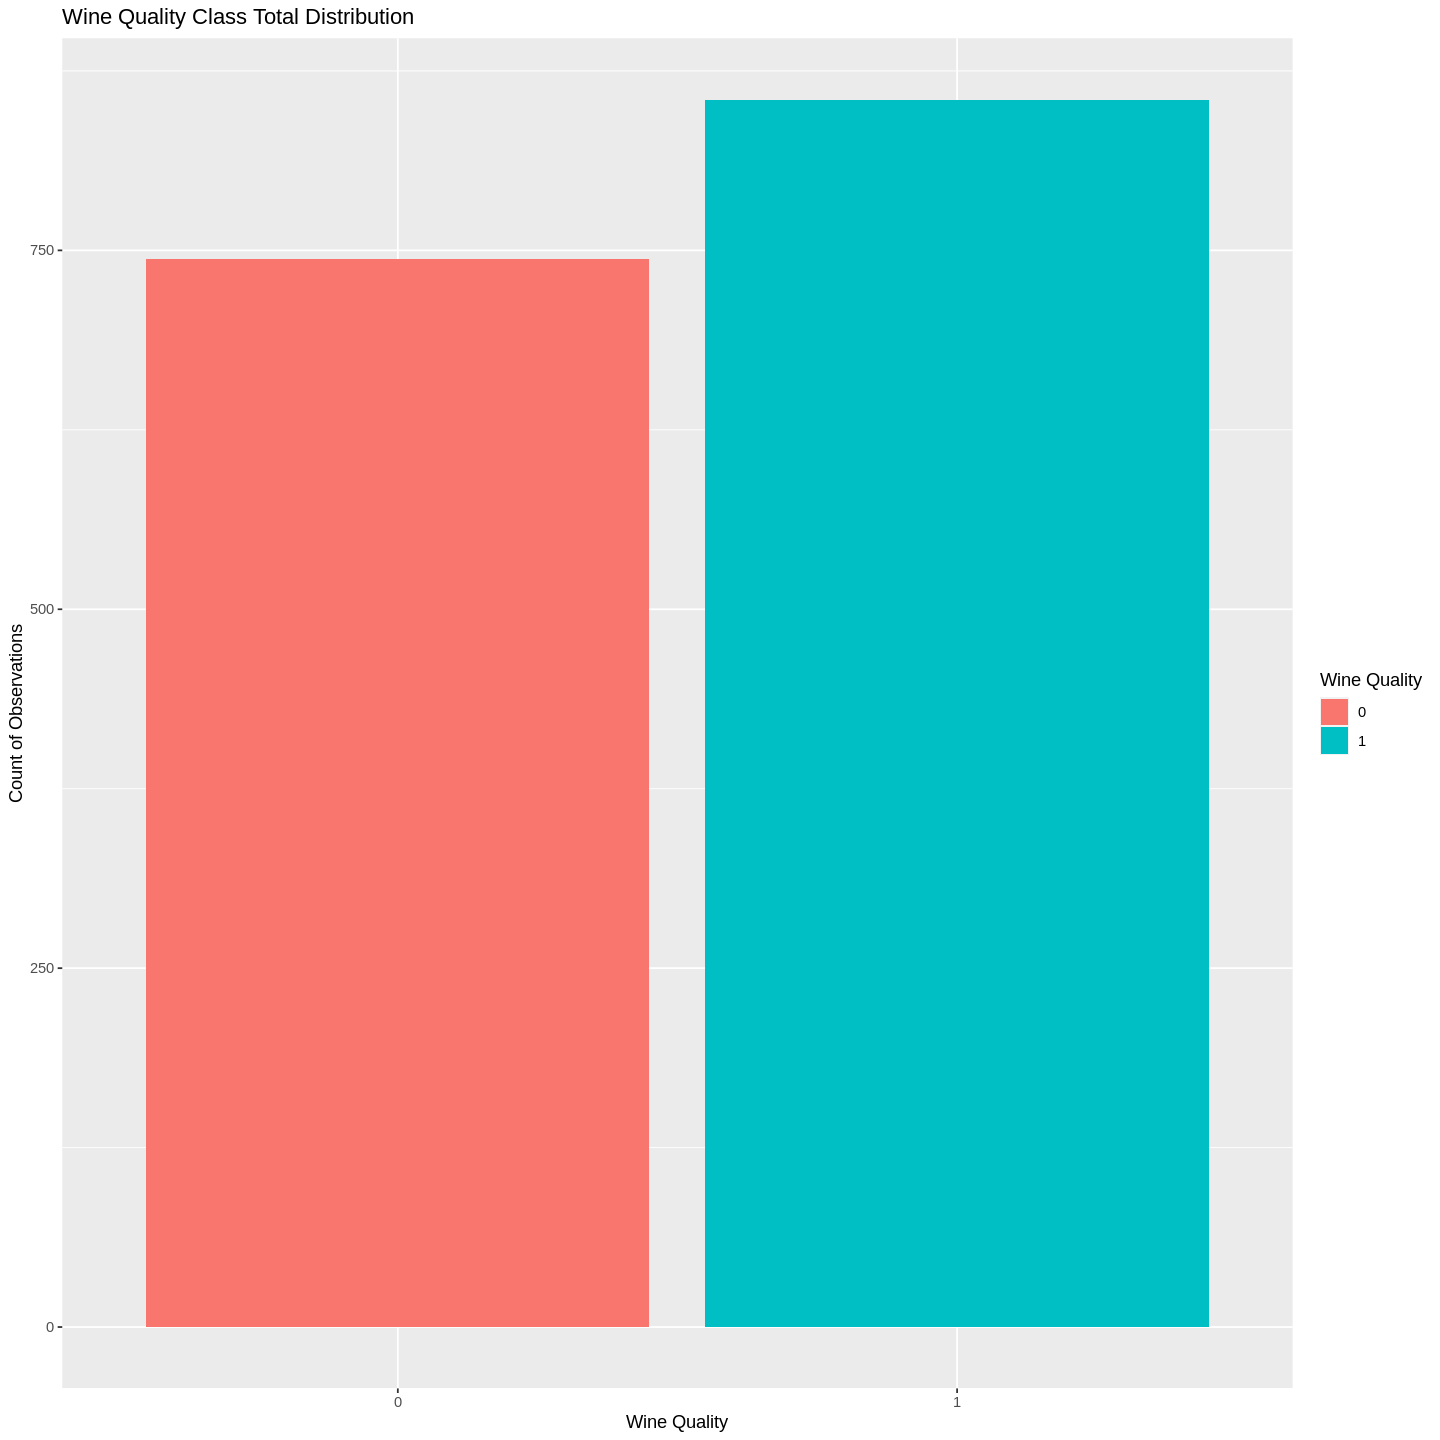

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


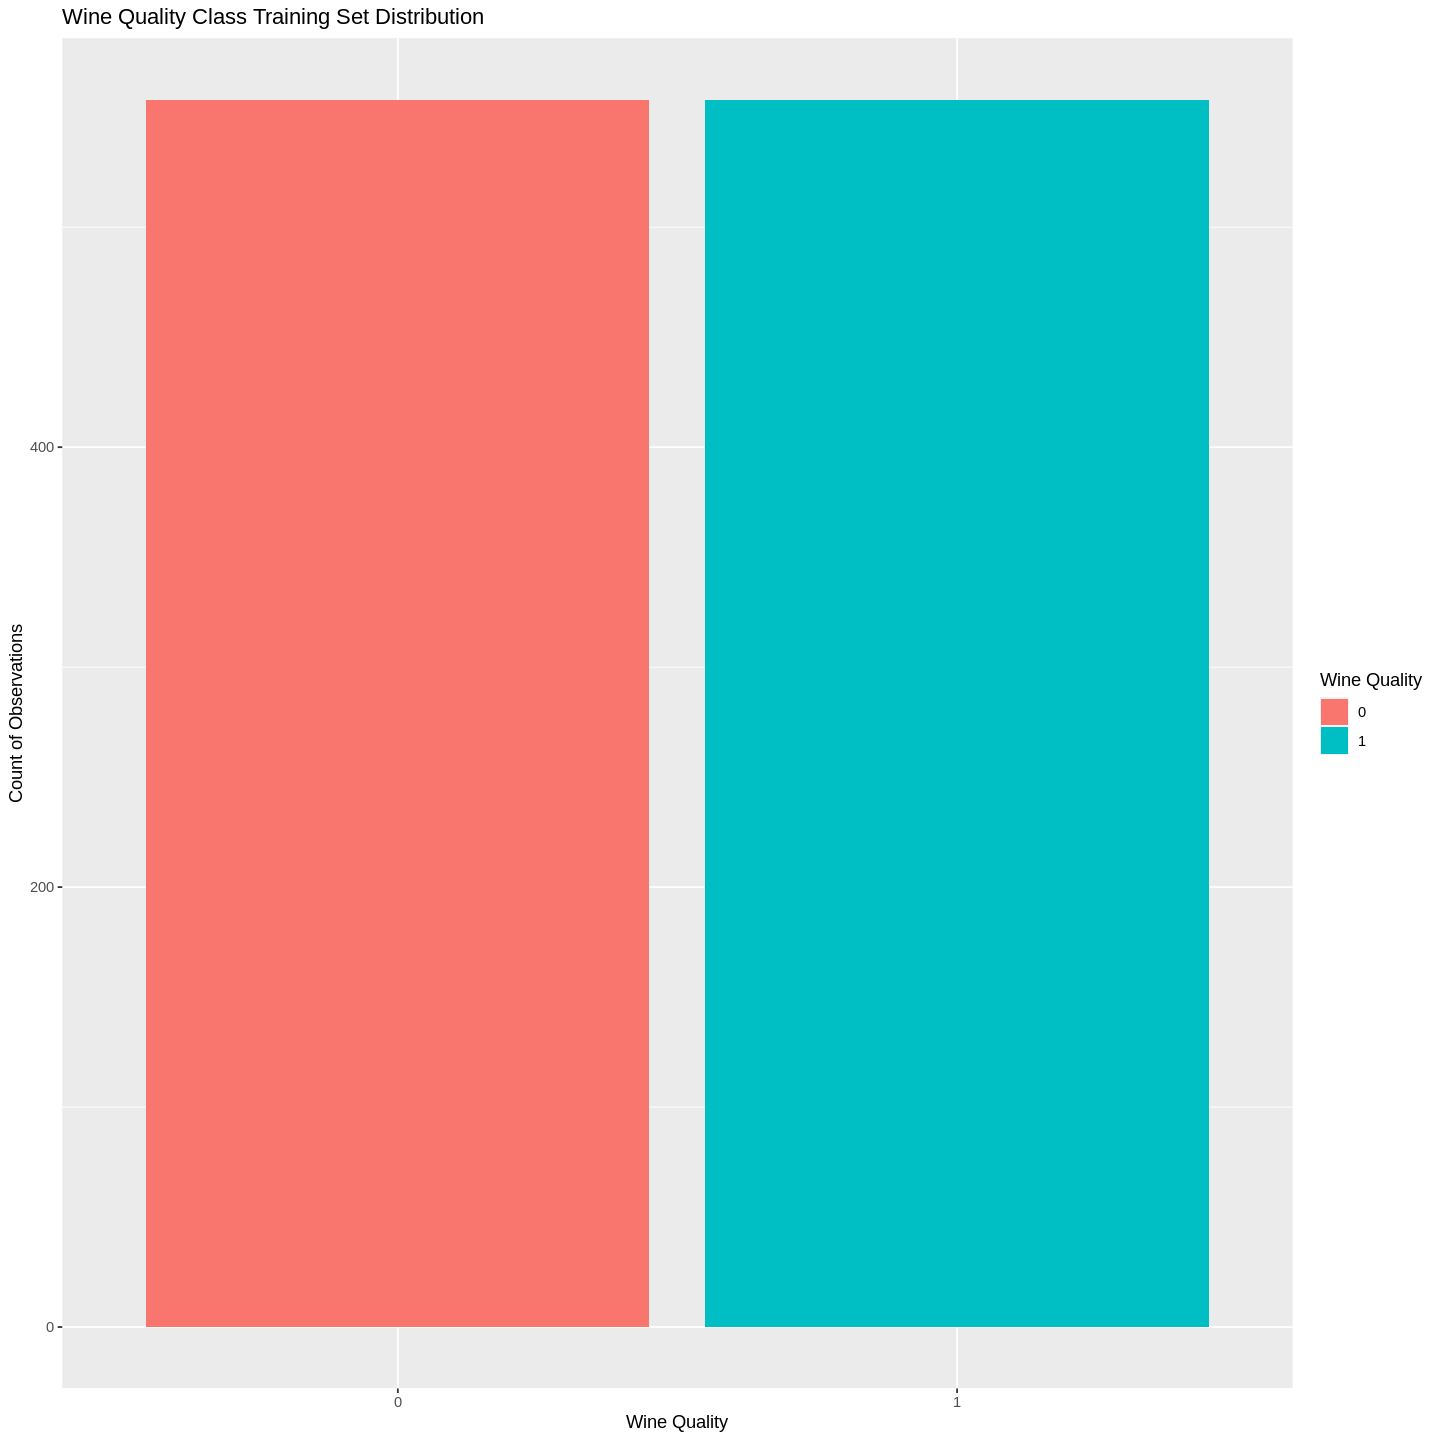

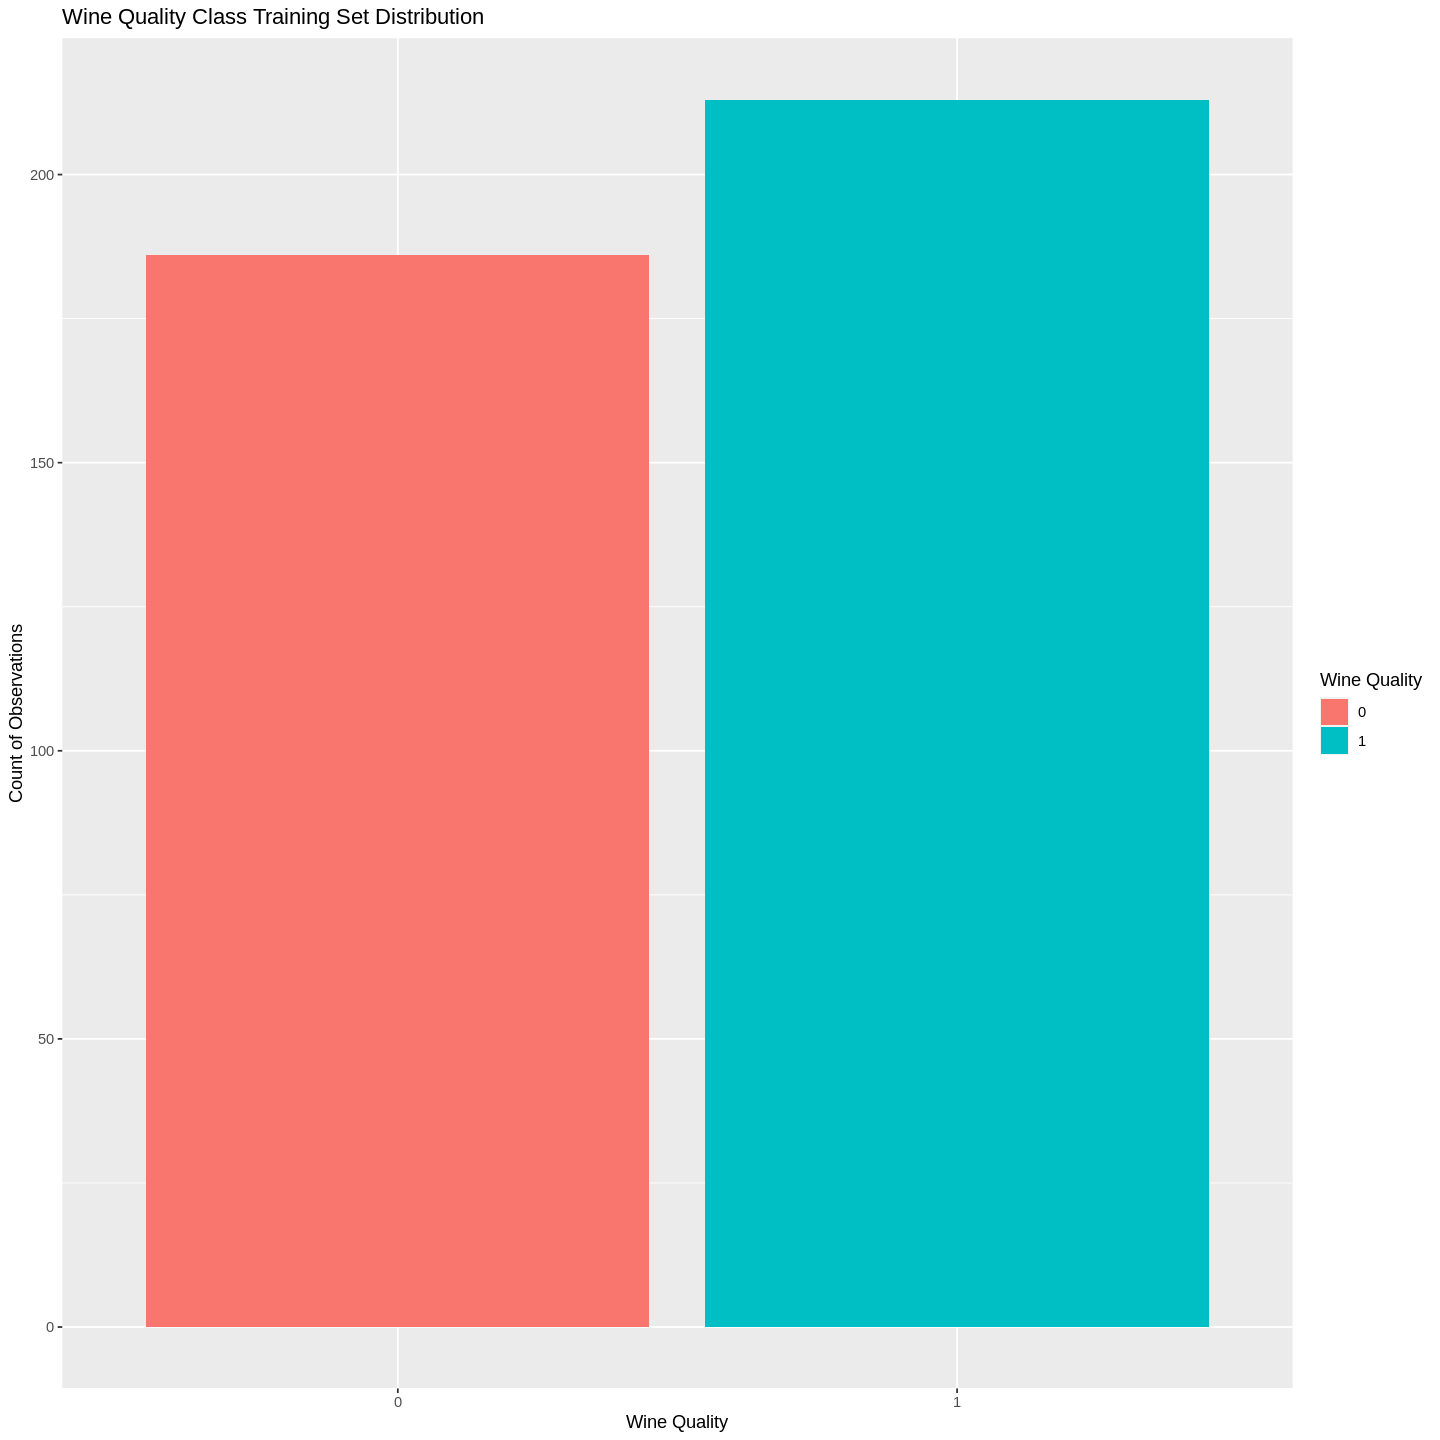

In [50]:
# Printing a binary histogram to demonstrate unbalanced overall data set
rw_bin_plot <- rw_bin %>%
    ggplot(aes(x = binary.quality, fill = binary.quality)) + 
    geom_histogram(binwidth = 0.5, stat = "count") +
    labs(x = "Wine Quality", y = "Count of Observations", fill = "Wine Quality", title = "Wine Quality Class Total Distribution")

rw_bin_plot

# Splitting into testing and training
rw_split <- initial_split(rw_bin, prop = 0.75, strata = binary.quality)
rw_train <- training(rw_split)
rw_test <- testing(rw_split)
# A 75-25 split means train data frame size = 1200, test size = 399, for a total of 1599

# Calculating length of good and bad classes on the train set
rw_train_bad <- rw_train[which(rw_train$binary.quality == 0),]
rw_train_good <- rw_train[which(rw_train$binary.quality == 1),]

rw_train_bad_size <- length(rw_train_bad$binary.quality)
rw_train_good_size <- length(rw_train_good$binary.quality)

# Downsampling the majority class of the training set to the size of the minority class
rw_train_good <- sample_n(rw_train_good, rw_train_bad_size)

# Combining both bad (minority) and good (former majority) data frames into one data frame
rw_train_combined <- rbind(rw_train_bad, rw_train_good)
# rw_train_combined # Print this to see it is unshuffled

# Shuffling the data frame as it is ordered in ascending order
rw_train_combined_shuffled <- rw_train_combined[sample(nrow(rw_train_combined)),]
# rw_train_combined_shuffled # Print this to see it is now shuffled

# Renaming the dataset
rw_train <- rw_train_combined_shuffled

# Demonstrating that the new training data set is equally balanced
rw_train_plot <- rw_train %>%
    ggplot(aes(x = binary.quality, fill = binary.quality)) + 
    geom_histogram(binwidth = 0.5, stat = "count") +
    labs(x = "Wine Quality", y = "Count of Observations", fill = "Wine Quality", title = "Wine Quality Class Training Set Distribution")

rw_train_plot


# Demonstrating that the testing data set remains imbalanced
rw_train_plot <- rw_test %>%
    ggplot(aes(x = binary.quality, fill = binary.quality)) + 
    geom_histogram(binwidth = 0.5, stat = "count") +
    labs(x = "Wine Quality", y = "Count of Observations", fill = "Wine Quality", title = "Wine Quality Class Training Set Distribution")

rw_train_plot

As the training set is balanced, but the testing set maintains the unbalanced characteristic of the original set, we begin forward selection. 

In [72]:

rw_train_subset <- rw_train %>%
    select(alcohol, volatile.acidity, total.sulfur.dioxide, sulphates, citric.acid, binary.quality)

predictors <- colnames(rw_train_subset %>% select(-binary.quality))

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-validation object
rw_vfold <- vfold_cv(rw_train_subset, v = 5, strata = binary.quality)

# store the total number of predictors
n_total <- length(predictors)
# these 5 are alcohol, Volatile acidity, Total sulfur dixoide, Sulphates, Citric acid as we found they had the highest relative Pearson correlation coefficients to the target variable

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(predictors)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, predictors[[j]])
        model_string <- paste("binary.quality", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        rw_recipe <- recipe(as.formula(model_string), 
                                data = rw_train_subset) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(rw_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = rw_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, predictors[[jstar]])
    predictors <- predictors[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,binary.quality ~ alcohol,0.6828266
2,binary.quality ~ alcohol+volatile.acidity,0.7347410
3,binary.quality ~ alcohol+volatile.acidity+sulphates,0.7490911
4,binary.quality ~ alcohol+volatile.acidity+sulphates+total.sulfur.dioxide,0.7840573
5,binary.quality ~ alcohol+volatile.acidity+sulphates+total.sulfur.dioxide+citric.acid,0.7481580


We now plot the graph to illustrate the diminishing accuracy as more variables are used for prediction

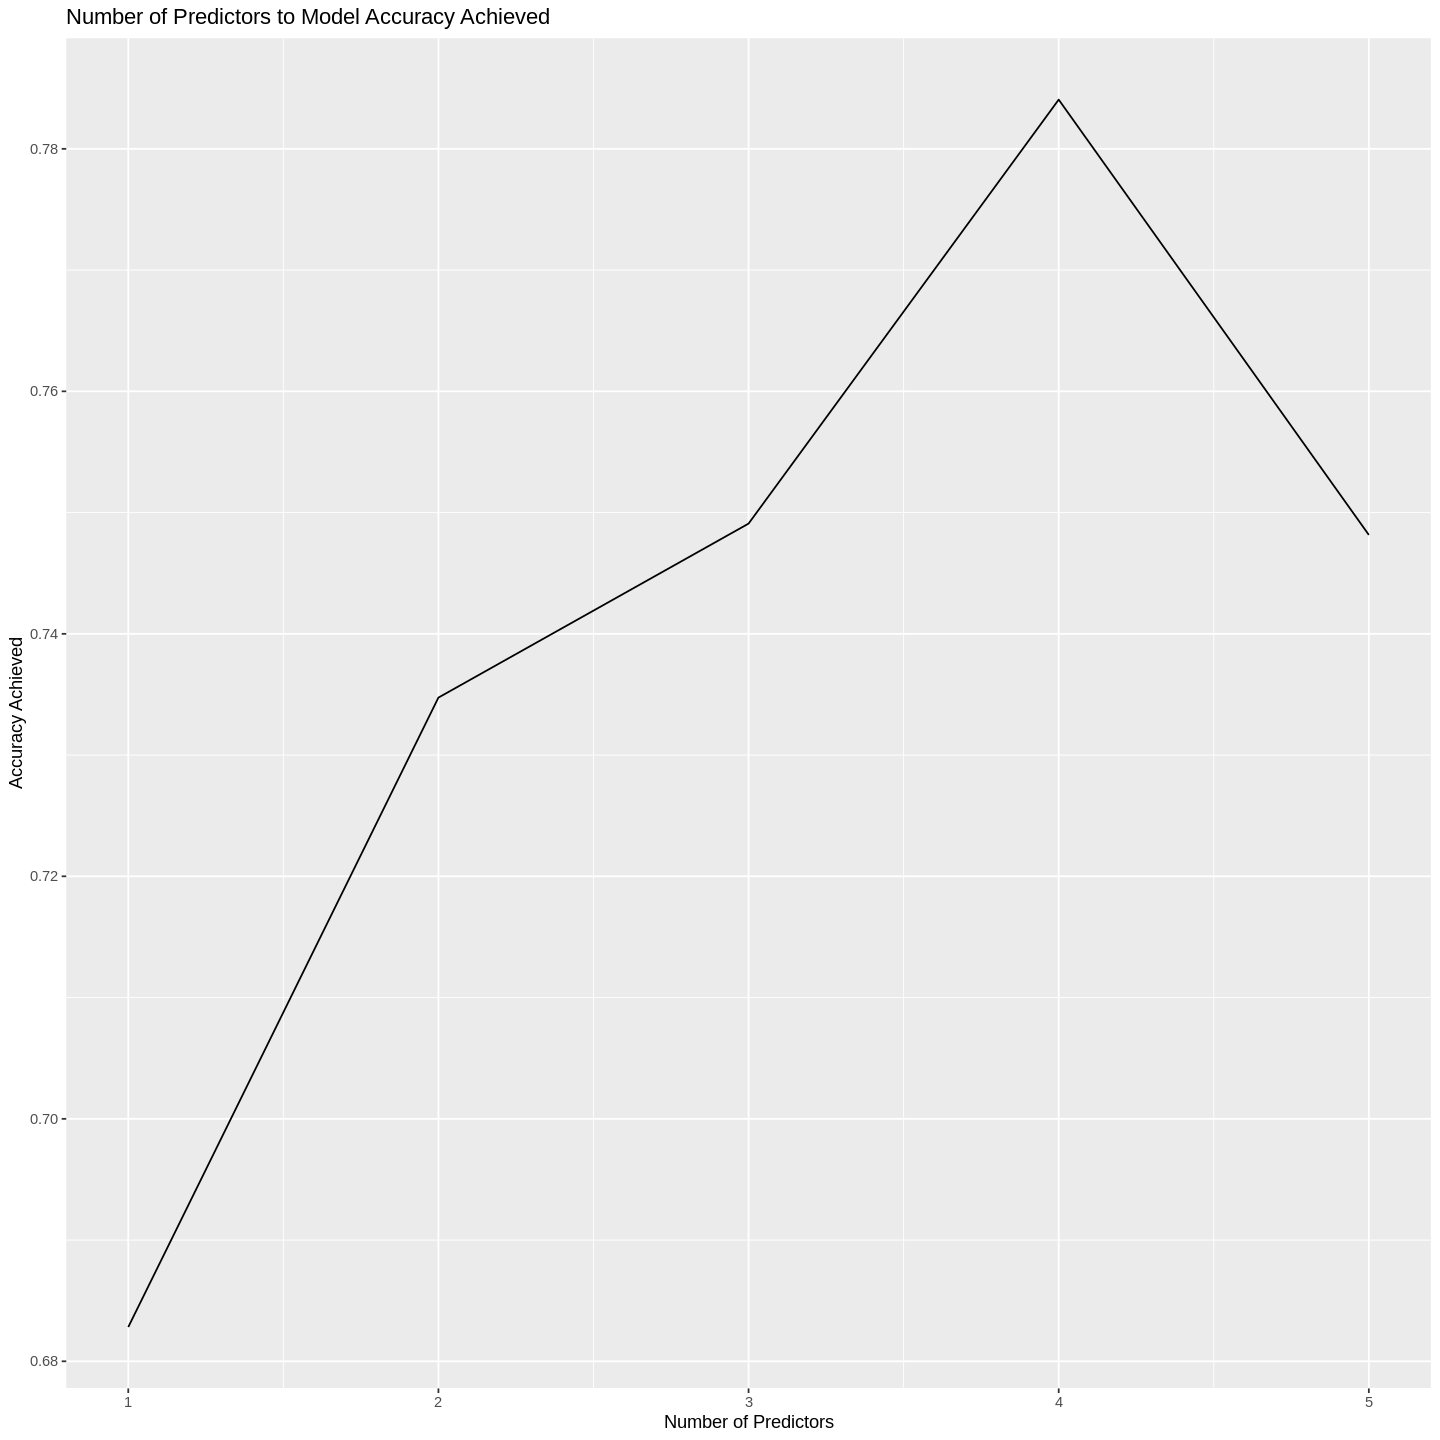

In [73]:
accuracies_plot <- accuracies %>%
    ggplot(aes(x = size, y = accuracy)) +
    geom_line() +
    labs(x = "Number of Predictors", y = "Accuracy Achieved", title = "Number of Predictors to Model Accuracy Achieved")

accuracies_plot

As illustrated above, the accuracy of the model diminishes as more variables are added. When using four the accuracy of the model is optimized. We now implement these four predictors in a new model.

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.7804698,5,0.01268916,Model1
4,accuracy,binary,0.7688626,5,0.00928177,Model2
6,accuracy,binary,0.7634894,5,0.01076287,Model3
8,accuracy,binary,0.7518742,5,0.01606575,Model4
9,accuracy,binary,0.7518903,5,0.01332457,Model5
11,accuracy,binary,0.7537082,5,0.01588573,Model6
12,accuracy,binary,0.7537082,5,0.01588573,Model7
13,accuracy,binary,0.7537082,5,0.01777300,Model8
14,accuracy,binary,0.7537082,5,0.01777300,Model9


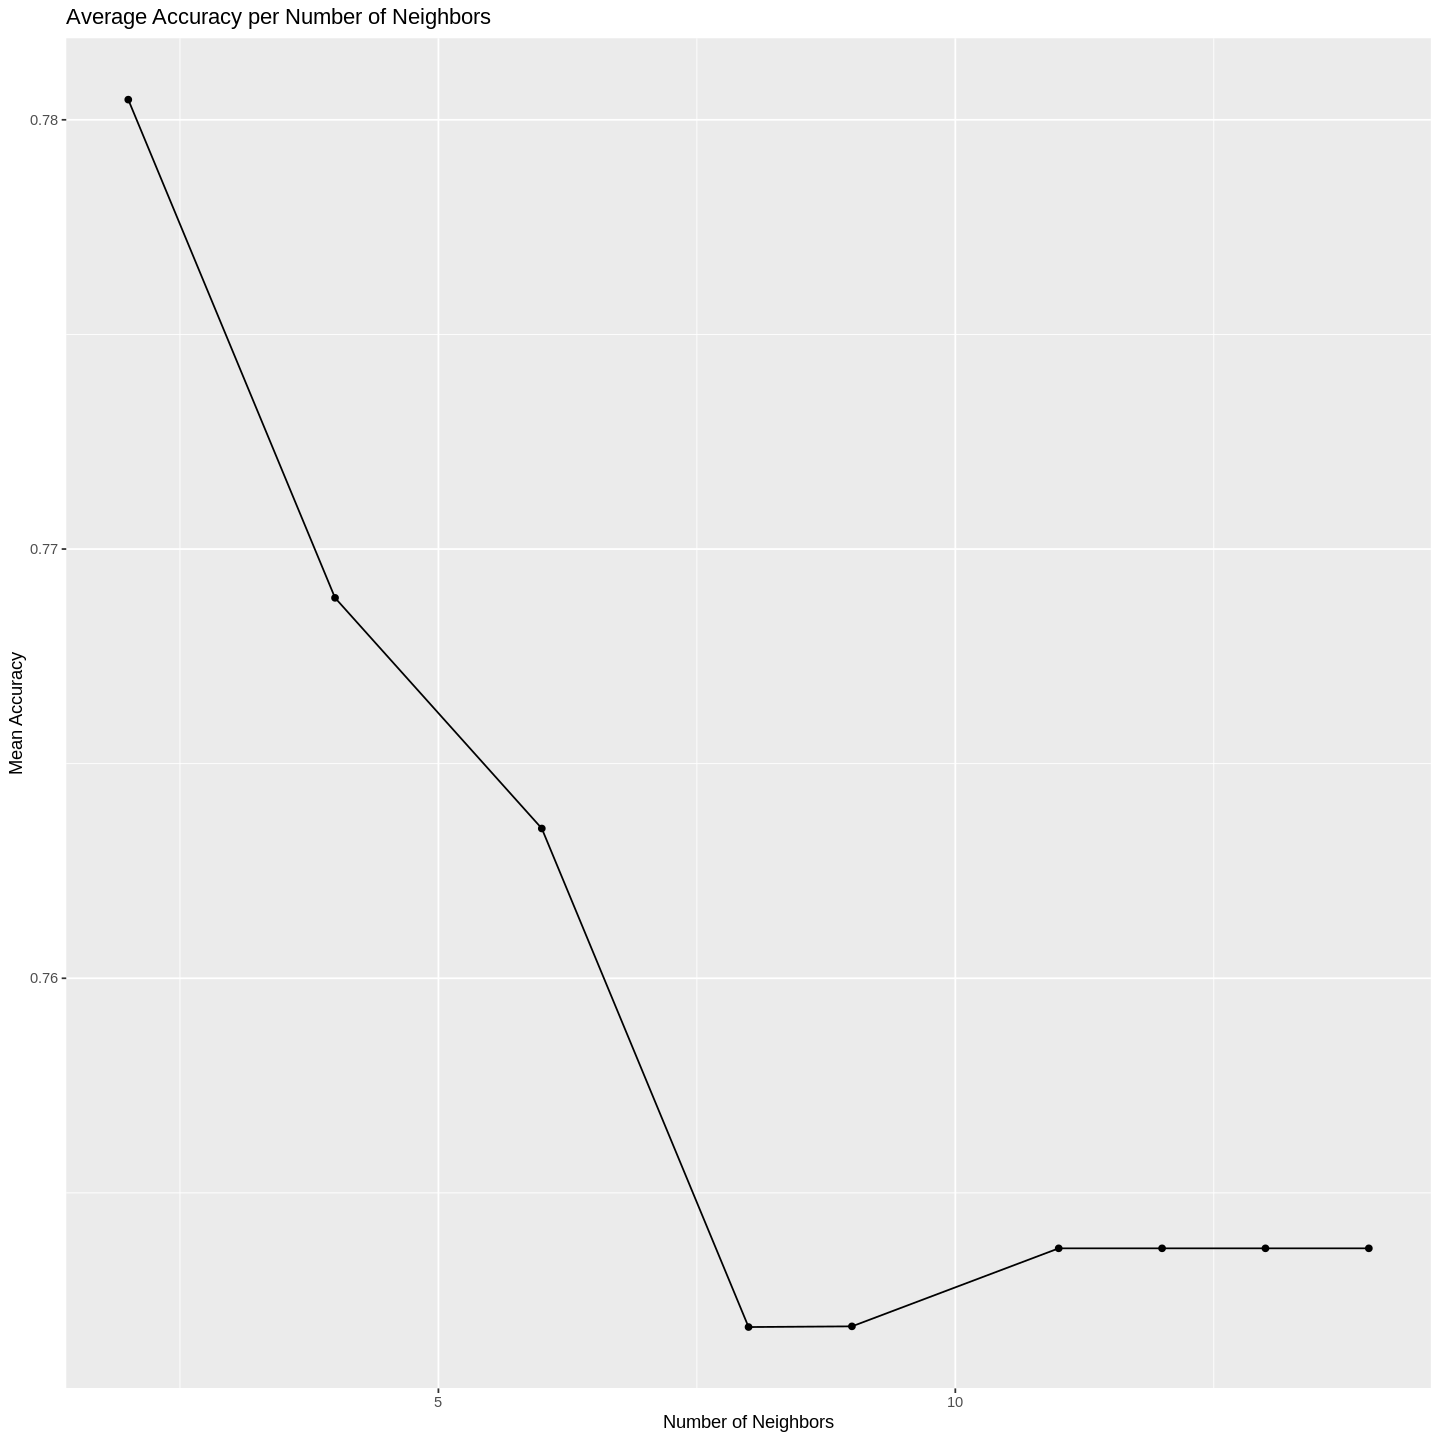

In [79]:
# Creating recipe
rw_recipe <- recipe(binary.quality ~ alcohol + volatile.acidity + sulphates + total.sulfur.dioxide, data = rw_train_subset) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

# Creating vfold
rw_vfold <- vfold_cv(rw_train_subset, v = 5, strata = binary.quality)

# Creating new nearest neighbors model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

rw_fit <- workflow() %>%
    add_recipe(rw_recipe) %>%
    add_model(knn_spec) %>%
    tune_grid(resamples = rw_vfold, grid = 10)

rw_metrics <- collect_metrics(rw_fit)

rw_metrics_accuracy <- rw_metrics %>%
                            filter(.metric == "accuracy")

cross_val_plot <- rw_metrics_accuracy %>%
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point() + 
    geom_line() + 
    labs(x = "Number of Neighbors", y = "Mean Accuracy", title = "Average Accuracy per Number of Neighbors")

rw_metrics_accuracy

cross_val_plot

In [82]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) %>%
            set_engine("kknn") %>%
            set_mode("classification")
                             
rw_fit <- workflow() %>%
    add_recipe(rw_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = rw_train_subset)

rw_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~2, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2535842
Best kernel: rectangular
Best k: 2

In [87]:
rw_predictions <- predict(rw_fit, rw_test) %>%
    bind_cols(rw_test)

rw_metrics <- rw_predictions %>%
    metrics(truth = binary.quality, estimate = .pred_class) %>%
    filter(.metric == "accuracy")

rw_conf_mat <- rw_predictions %>% 
      conf_mat(truth = binary.quality, estimate = .pred_class)

rw_metrics
rw_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7318296


          Truth
Prediction   0   1
         0 141  62
         1  45 151

Accuracy of 73%